## Agent Supervisor

The [previous example](multi-agent-collaboration.ipynb) routed messages automatically based on the output of the initial researcher agent.

We can also choose to use an LLM to orchestrate the different agents.

Below, we will create an agent group, with an agent supervisor to help delegate tasks.

![diagram](./img/supervisor-diagram.png)

To simplify the code in each agent node, we will use the AgentExecutor class from LangChain. This and other "advanced agent" notebooks are designed to show how you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

Before we build, let's configure our environment:

In [1]:
# %%capture --no-stderr
# %pip install -U langchain langchain_openai langchain_experimental langsmith pandas

In [2]:
# import getpass
# import os


# def _set_if_undefined(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass(f"Please provide your {var}")


# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")

# Optional, add tracing in LangSmith
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

In [3]:
import logging
from dotenv import load_dotenv

In [4]:
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

load_dotenv()

True

## Create tools

For this example, you will make an agent to do web research with a search engine, and one agent to create plots. Define the tools they'll use below:

In [5]:
from typing import Annotated, List, Tuple, Union

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

## Helper Utilities

Define a helper function below, which make it easier to add new agent worker nodes.

In [6]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI


def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

We can also define a function that we will use to be the nodes in the graph - it takes care of converting the agent response to a human message. This is important because that is how we will add it the global state of the graph

In [7]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Create Agent Supervisor

It will use function calling to choose the next worker node OR finish processing.

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members
# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4o")

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

## Construct Graph

We're ready to start building the graph. Below, define the state and worker nodes using the function we just defined.

In [9]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_agent(llm, [tavily_tool], "You are a web researcher.")
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_agent(
    llm,
    [python_repl_tool],
    "You may generate safe python code to analyze data and generate charts using matplotlib.",
)
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_chain)

Now connect all the edges in the graph.

In [10]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.set_entry_point("supervisor")

graph = workflow.compile()

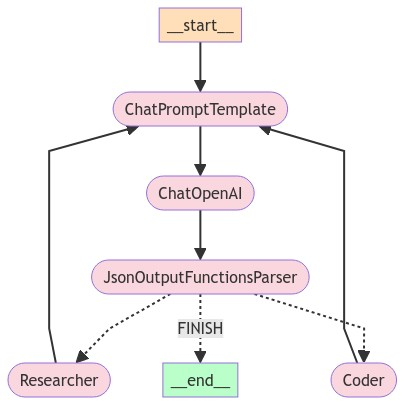

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## Invoke the team

With the graph created, we can now invoke it and see how it performs!

In [12]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': 'Coder'}}
----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'Coder': {'messages': [HumanMessage(content='The code executed successfully and printed `Hello, World!` to the terminal.', name='Coder')]}}
----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': 'FINISH'}}
----


In [13]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Write a brief research report on pikas.")]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': 'Researcher'}}
----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'Researcher': {'messages': [HumanMessage(content='### Research Report on Pikas\n\n#### Introduction\nPikas are small, herbivorous mammals belonging to the family Ochotonidae and are closely related to rabbits and hares. These small, round creatures are known for their high-pitched alarm calls and are often found in cold, rocky environments. This report delves into various aspects of pikas, including their habitat, behavior, diet, and conservation status.\n\n#### Habitat and Behavior\nPikas are primarily found in mountainous regions in the Northern Hemisphere, particularly in North America and Asia. They inhabit rocky slopes known as talus, where they find protection from predators and harsh weather conditions. In North America, the American pika (Ochotona princeps) is commonly found in the mountains of the western United States, from central British Columbia to New Mexico.\n\nThese animals are diurnal and remain active throughout the year, including winter. Unlike many mammals, pikas 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': 'Coder'}}
----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'Coder': {'messages': [HumanMessage(content='### References\n\n1. **Smith, A. T., & Weston, M. L.** (1990). Ochotona princeps. Mammalian Species, (352), 1-8.\n2. **Beever, E. A., Ray, C., Wilkening, J. L., Brussard, P. F., & Mote, P. W.** (2011). Contemporary Climate Change Alters the Pace and Drivers of Extinction. Global Change Biology, 17(6), 2054-2070.\n3. **U.S. Geological Survey** (2020). Pikas in Peril: Vulnerability of American Pikas to Climate Change. Retrieved from [USGS Website](https://www.usgs.gov/centers/nwhc/science/pikas-peril).\n4. **International Union for Conservation of Nature (IUCN)**. (2020). The IUCN Red List of Threatened Species. Retrieved from [IUCN Red List](https://www.iucnredlist.org/).\n\n### Acknowledgements\n\nThis report was compiled using data and insights from various researchers and organizations dedicated to the study and conservation of pikas. Their contributions to wildlife research are invaluable in understanding and protecting these unique mamm

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': 'FINISH'}}
----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': 'Researcher'}}
----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'Researcher': {'messages': [HumanMessage(content="From the search results, I have found the following UK GDP data for the last 5 years:\n\n- **2021:** $3,141.51 billion\n- **2020:** $2,697.81 billion\n- **2019:** $2,851.41 billion\n- **2018:** $2,870.08 billion\n- **2017:** $2,857.48 billion\n\nUsing this data, I'll draw a line graph to visualize the trend in the UK's GDP over these years.\n\nHere is the Python code to generate the line graph using Matplotlib:\n\n```python\nimport matplotlib.pyplot as plt\n\n# Data\nyears = [2017, 2018, 2019, 2020, 2021]\ngdp = [2857.48, 2870.08, 2851.41, 2697.81, 3141.51]\n\n# Create the plot\nplt.figure(figsize=(10, 5))\nplt.plot(years, gdp, marker='o', linestyle='-', color='b')\n\n# Adding titles and labels\nplt.title('UK GDP Over the Last 5 Years')\nplt.xlabel('Year')\nplt.ylabel('GDP (in billion USD)')\n\n# Show the plot\nplt.grid(True)\nplt.show()\n```\n\nYou can run this code in your local Python environment to generate the line graph. The grap

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': 'Coder'}}
----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str
INFO:matplotlib.font_manager:generated new fontManager
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


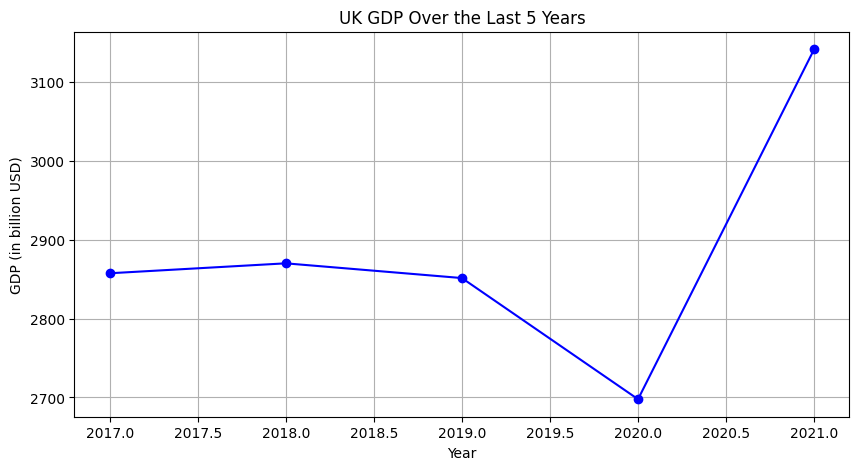

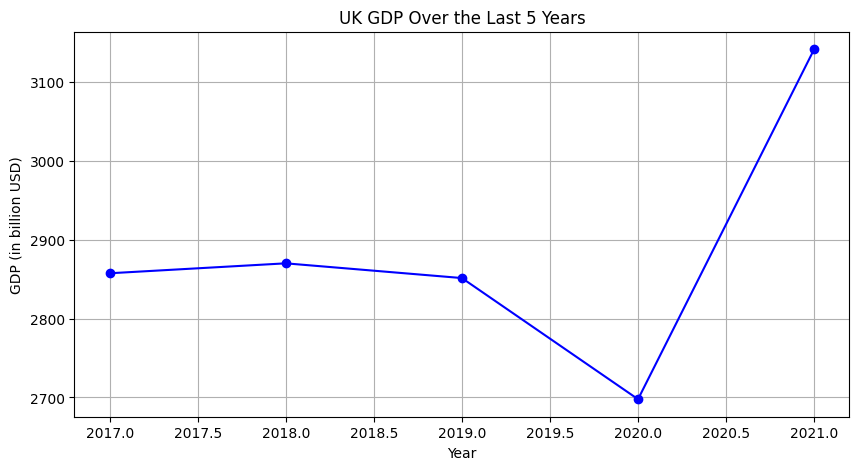

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'Coder': {'messages': [HumanMessage(content="The line graph illustrating the UK's GDP over the past 5 years has been successfully generated. The GDP data points over the years 2017 to 2021 have been plotted, showing the trends and fluctuations during this period.", name='Coder')]}}
----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'supervisor': {'next': 'FINISH'}}
----


In [14]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")